In [1]:
%load_ext jupyter_black

In [6]:
from glob import glob
from datetime import datetime

import pandas as pd
import xarray as xr

In [7]:
def open_sat_data(glob_like_path: str) -> xr.Dataset:
    def generate() -> xr.Dataset:
        for file in glob(glob_like_path):
            # have to open the files one at a time because theres no validTime dim set by netcdf4?
            ds = xr.open_dataset(file, engine="netcdf4", chunks="auto", use_cftime=True)
            # iterate y, m, d, h, m, s and index the attrs to create a datetime object
            ts = datetime(*(int(ds.attrs[x]) for x in ("year", "month", "day", "hour", "minute", "second")))
            # print(ts)
            # expand the dev with the timestamp value and yeild the dataset
            yield ds.expand_dims({"validTime": [ts.timestamp()]})

    #  concatnate the data on the validTime dimension
    return xr.concat(generate(), dim="validTime")


# open a list of sat files
ds = open_sat_data("/workspaces/griblib/archive/*_nc")
ds

<xarray.Dataset>
Dimensions:    (MSL_alt: 16093, validTime: 36)
Coordinates:
  * MSL_alt    (MSL_alt) float32 0.1058 0.1488 0.169 ... 835.3 835.4 835.6
  * validTime  (validTime) float64 1.579e+09 1.579e+09 ... 1.579e+09 1.579e+09
Data variables:
    GEO_lat    (validTime, MSL_alt) float32 dask.array<chunksize=(1, 16093), meta=np.ndarray>
    GEO_lon    (validTime, MSL_alt) float32 dask.array<chunksize=(1, 16093), meta=np.ndarray>
    OCC_azi    (validTime, MSL_alt) float32 dask.array<chunksize=(1, 16093), meta=np.ndarray>
    TEC_cal    (validTime, MSL_alt) float32 dask.array<chunksize=(1, 16093), meta=np.ndarray>
    ELEC_dens  (validTime, MSL_alt) float32 dask.array<chunksize=(1, 16093), meta=np.ndarray>
Attributes: (12/51)
    occ_id:            0
    fiducial_id:           
    reference_sat_id:  -999
    occulting_sat_id:  10
    year:              2020
    month:             1
    ...                ...
    fileStamp:         C006.2020.009.16.22.G10
    inverter:          gmrion
    parmsfile:         parms8
    center:            UCAR/CDAAC
    mission:           COSMIC
    creation_time:     06-MAR-20 05:48

In [8]:
def to_datetime(df: pd.DataFrame, time_column="validTime"):
    df[time_column] = df[time_column].astype("datetime64[s]")
    return df


df = (
    # dataset to dataframe
    ds.to_dataframe()
    # reset the index to we can grab the valid times
    .reset_index()
    # calling the pipe method to turn POSIX time into datetime objects
    .pipe(to_datetime)
    # update our index
    .set_index(["validTime", "MSL_alt", "GEO_lat", "GEO_lon"])
    # drop rows with na
    .dropna(axis=0, how="all")
)
df

,,,,OCC_azi,TEC_cal,ELEC_dens
validTime,MSL_alt,GEO_lat,GEO_lon,,,
2020-01-09 12:47:50,0.105839,-21.061815,-17.407858,8.873467,100.379578,-132302.171875
2020-01-09 17:32:50,0.148841,38.609314,-108.179146,26.567747,49.669487,1928.172485
2020-01-09 16:40:24,0.168985,-50.168381,71.412903,175.372772,27.965189,43412.187500
2020-01-09 13:14:51,0.221322,-56.066246,92.076050,-132.743744,36.371437,11886.642578
2020-01-09 13:40:14,0.266322,45.914852,164.135376,-163.007645,69.038605,55002.234375
...,...,...,...,...,...,...
2020-01-09 15:57:54,835.093933,30.720913,-101.458092,-56.755951,0.625098,29550.847656
2020-01-09 12:31:29,835.285461,42.187160,-55.072266,-26.970804,0.214227,8663.916992
2020-01-09 17:37:06,835.338074,31.747385,-127.079155,-45.724815,0.502910,22299.529297


<GeoAxesSubplot:xlabel='GEO_lon', ylabel='GEO_lat'>

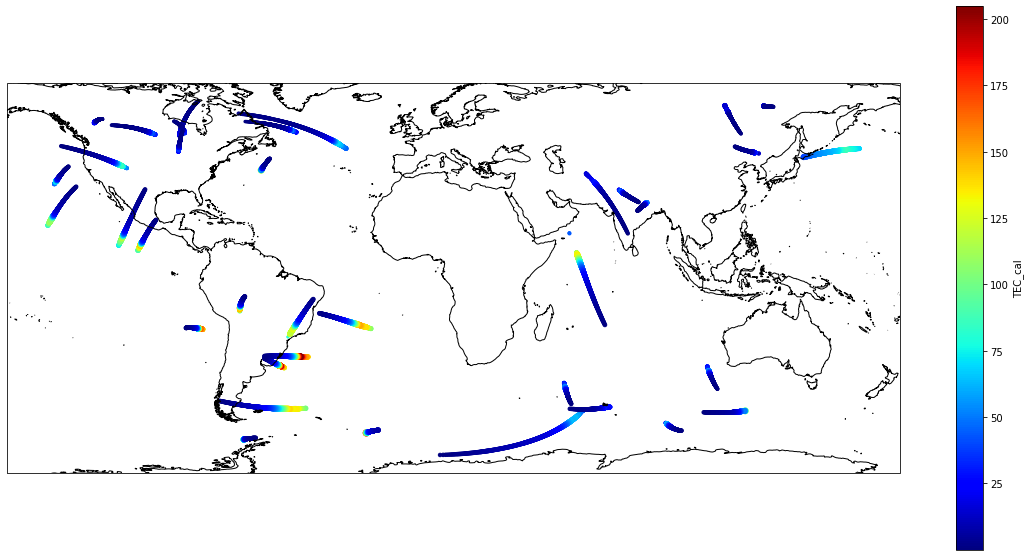

In [9]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

ax = plt.subplot(111, aspect="equal", projection=ccrs.PlateCarree())
ax.coastlines("50m")
df.reset_index(["GEO_lat", "GEO_lon"]).plot.scatter(
    y="GEO_lat",
    x="GEO_lon",
    ax=ax,
    s=df["ELEC_dens"] ** 0.25,
    c="TEC_cal",
    cmap=plt.get_cmap("jet"),
    figsize=(20, 10),
)